In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp

# _FOLDER = "/home/acq18mk/master/results/results/"
_FOLDER = "/home/juanjo/Work_Postdoc/Bench_Mark_DrugResponse_Models/Functional-Random-forest-master/GDSC1_Small_Dataset/"

In [2]:
df_train = pd.read_csv(_FOLDER+"PI3k_train.csv")  #Contain dataset prepared by Subhashini
df_test = pd.read_csv(_FOLDER+"PI3K_test.csv")  #Contain dataset prepared by Subhashini

In [3]:
df_train[df_train.columns[513]]  #this column called "molecular_formula" is not processed to be a float

0         C30H23N5O
1      C19H21F2N7O2
2        C19H16N4O3
3        C21H22N6O3
4        C25H31N5O4
           ...     
379      C19H21F3N6
380      C56H87NO16
381    C35H28F3N5O2
382      C21H27N7O3
383       C34H29N7O
Name: molecular_formula, Length: 384, dtype: object

In [4]:
df_test[df_test.columns[513]]  #this column called "molecular_formula" is not processed to be a float

0       C21H22N6O3
1        C25H21N5O
2     C23H27N7O3S2
3        C30H23N5O
4       C25H31N5O4
          ...     
91      C19H21F3N6
92       C34H29N7O
93      C56H87NO16
94      C56H87NO16
95     C20H23BrN8O
Name: molecular_formula, Length: 96, dtype: object

In [5]:
# we realised that the column "molecular_formula" is a string like
df_train_without_molecular_formula = df_train.drop(columns='molecular_formula') 
df_test_without_molecular_formula = df_test.drop(columns='molecular_formula') 

In [6]:
df_train_without_molecular_formula

,Drug Name,Target,Target_Pathway,DRUG_ID,COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,AKT1,PI3Kbeta,MTORC2,PI3Kgamma,CLK4,DAPK3,PI3K (class 1),HIPK2,S6K1,MTOR
0,Dactolisib,"PI3K (Class 1), MTORC1, MTORC2",PI3K/MTOR signaling,1057,722066,0.25,0,0.111111,0.222222,0.333333,...,0,0,1,0,0,0,0,0,0,0
1,ZSTK474,PI3K (class 1),PI3K/MTOR signaling,223,722066,5.12,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,1,0,0,0
2,PI-103,"PI3Kalpha, DAPK3, CLK4, PIM3, HIPK2",PI3K/MTOR signaling,302,724868,10.24,0,0.111111,0.222222,0.333333,...,0,0,0,0,1,1,0,1,0,0
3,OSI-027,"MTORC1, MTORC2",PI3K/MTOR signaling,299,1240190,20.00,0,0.111111,0.222222,0.333333,...,0,0,1,0,0,0,0,0,0,0
4,AZD8055,"MTORC1, MTORC2",PI3K/MTOR signaling,1059,908475,2.00,0,0.111111,0.222222,0.333333,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,PF-4708671,S6K1,PI3K/MTOR signaling,1129,687802,10.00,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,1,0
380,Temsirolimus,MTOR,PI3K/MTOR signaling,1016,1240190,0.20,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,1
381,JW-7-52-1,MTOR,PI3K/MTOR signaling,83,908473,1.20,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,1
382,GSK690693,"AKT1, AKT2, AKT3",PI3K/MTOR signaling,326,908460,10.24,0,0.111111,0.222222,0.333333,...,1,0,0,0,0,0,0,0,0,0


In [7]:
df_test_without_molecular_formula

,Drug Name,Target,Target_Pathway,DRUG_ID,COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,AKT1,PI3Kbeta,MTORC2,PI3Kgamma,CLK4,DAPK3,PI3K (class 1),HIPK2,S6K1,MTOR
0,OSI-027,"MTORC1, MTORC2",PI3K/MTOR signaling,299,907786,20.00,0,0.111111,0.222222,0.333333,...,0,0,1,0,0,0,0,0,0,0
1,MK-2206,"AKT1, AKT2",PI3K/MTOR signaling,1053,753600,4.00,0,0.111111,0.222222,0.333333,...,1,0,0,0,0,0,0,0,0,0
2,Pictilisib,PI3K (class 1),PI3K/MTOR signaling,1058,1503370,4.00,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,1,0,0,0
3,Dactolisib,"PI3K (Class 1), MTORC1, MTORC2",PI3K/MTOR signaling,1057,1240145,2.00,0,0.111111,0.222222,0.333333,...,0,0,1,0,0,0,0,0,0,0
4,AZD8055,"MTORC1, MTORC2",PI3K/MTOR signaling,1059,1287381,2.00,0,0.111111,0.222222,0.333333,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,PF-4708671,S6K1,PI3K/MTOR signaling,1129,687798,10.00,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,1,0
92,AKT inhibitor VIII,"AKT1, AKT2, AKT3",PI3K/MTOR signaling,228,687812,10.24,0,0.111111,0.222222,0.333333,...,1,0,0,0,0,0,0,0,0,0
93,Temsirolimus,MTOR,PI3K/MTOR signaling,1016,1503369,0.20,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,1
94,Temsirolimus,MTOR,PI3K/MTOR signaling,1016,1298348,0.20,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,1


In [8]:
 #Checking if both train and test have the same names for their columns
(df_train_without_molecular_formula.columns==df_test_without_molecular_formula.columns).sum()  

551

In [9]:
All_data_together = pd.concat([df_train_without_molecular_formula[df_train_without_molecular_formula.columns[30:]], df_test_without_molecular_formula[df_test_without_molecular_formula.columns[30:]]])

In [10]:
#All_data_together.columns[488]
#All_data_together.columns[482]
#All_data_together[All_data_together.columns[482]]
print("Columns with std equal zero:")
np.where(All_data_together.std(0)==0.0)
#(All_data_together.std(0)==0.0).sum()

Columns with std equal zero:


(array([482, 488]),)

In [11]:
print(All_data_together.columns[482])
print(All_data_together.columns[488])

covalent_unit_count
N


In [12]:
All_data_together["N"].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [13]:
#We get rid of the two columns with std == 0
df_train_clean = df_train_without_molecular_formula.drop(columns=['covalent_unit_count','N'])
df_test_clean = df_test_without_molecular_formula.drop(columns=['covalent_unit_count','N'])

In [14]:
print("std for features train:", (df_train_clean[df_train_clean.columns[30:]].std(0)==0.0).sum() )
print("std for features test:", (df_test_clean[df_test_clean.columns[30:]].std(0)==0.0).sum() )

std for features train: 0
std for features test: 35


In [15]:
df_train_values = df_train_clean[df_train_clean.columns[30:]].values
df_test_values = df_test_clean[df_test_clean.columns[30:]].values

In [19]:
#df_test_clean.columns[30]
#X_train_features = df_train_clean[df_train_clean.columns[30:]].values
#X_test_features = df_test_clean[df_test_clean.columns[30:]].values

scaler = MinMaxScaler().fit(df_train_clean[df_train_clean.columns[30:]])
X_train_features = scaler.transform(df_train_clean[df_train_clean.columns[30:]])
X_test_features = scaler.transform(df_test_clean[df_test_clean.columns[30:]])


In [20]:
y_train_drug = np.clip(df_train_clean["norm_cells_"+str(1)].values[:,None],1.0e-9,np.inf)
y_test_drug =  np.clip(df_test_clean["norm_cells_"+str(1)].values[:,None],1.0e-9,np.inf)
print(y_train_drug.shape)
for i in range(2,10):
    y_train_drug = np.concatenate((y_train_drug,np.clip(df_train_clean["norm_cells_"+str(i)].values[:,None],1.0e-9,np.inf)),1)
    y_test_drug = np.concatenate((y_test_drug,np.clip(df_test_clean["norm_cells_"+str(i)].values[:,None],1.0e-9,np.inf)),1)

(384, 1)


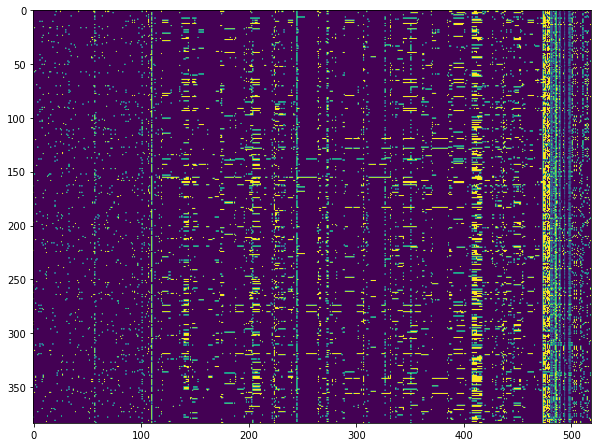

In [21]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(10,40))
plt.imshow(X_train_features)

In [22]:
y_test_drug.shape

(96, 9)

In [23]:
params_4_sig_train = df_train_clean["param_"+str(1)].values[:,None]
params_4_sig_test = df_test_clean["param_"+str(1)].values[:,None]
for i in range(2,5):
    params_4_sig_train = np.concatenate((params_4_sig_train,df_train_clean["param_"+str(i)].values[:,None]),1)
    params_4_sig_test = np.concatenate((params_4_sig_test,df_test_clean["param_"+str(i)].values[:,None]),1)

In [24]:
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

In [25]:
# from sklearn import metrics
# for i in range(val_y.numpy().shape[0]):
#     AUC_val = metrics.auc(np.linspace(0.11,1,9),val_y.numpy()[i,:])
#     AUC_pred = metrics.auc(np.linspace(0.11, 1, 9), mean.numpy()[i, :])
#     myAUC_Err[i] = np.abs(AUC_val-AUC_pred)

0.3146524874593855


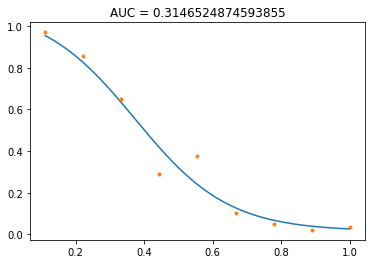

In [27]:
import matplotlib.pyplot as plt
from sklearn import metrics
x_lin = np.linspace(0.111111,1,1000)
x_real_dose = np.linspace(0.111111,1,9)
x_lin_tile = np.tile(x_lin,(params_4_sig_train.shape[0],1))
#(x_lin,params_4_sig_train.shape[0],1).shape
Ydose_res = []
AUC = []
for i in range(params_4_sig_train.shape[0]):
    Ydose_res.append(sigmoid_4_param(x_lin_tile[i,:],*params_4_sig_train[i,:]))
    AUC.append(metrics.auc(x_lin_tile[i,:],Ydose_res[i]))

posy = 12        
plt.plot(x_lin,Ydose_res[posy])
plt.plot(x_real_dose,y_train_drug[posy,:],'.')
plt.title(f"AUC = {AUC[posy]}")
print(AUC[posy])

0.6016042801704277


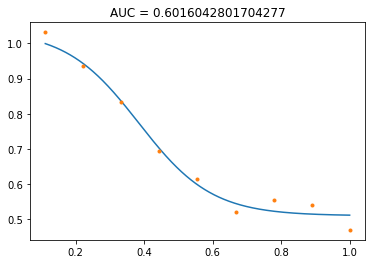

In [28]:
import matplotlib.pyplot as plt
from sklearn import metrics
x_lin = np.linspace(0.111111,1,1000)
x_real_dose = np.linspace(0.111111,1,9)
x_lin_tile = np.tile(x_lin,(params_4_sig_test.shape[0],1))
#(x_lin,params_4_sig_train.shape[0],1).shape
Ydose_res_test = []
AUC_test = []
for i in range(params_4_sig_test.shape[0]):
    Ydose_res_test.append(sigmoid_4_param(x_lin_tile[i,:],*params_4_sig_test[i,:]))
    AUC_test.append(metrics.auc(x_lin_tile[i,:],Ydose_res_test[i]))

posy = 12        
plt.plot(x_lin,Ydose_res_test[posy])
plt.plot(x_real_dose,y_test_drug[posy,:],'.')
plt.title(f"AUC = {AUC_test[posy]}")
print(AUC_test[posy])

# Compute Log(AUC)? R/ Not for Functional Random Forest Model

In [29]:
#Here we make the log(AUC) as in the papers they authors usually use the log(IC50) as target.
#AUC = np.log(np.array(AUC))
AUC = np.array(AUC)
AUC_test = np.array(AUC_test)

19.595917942265423

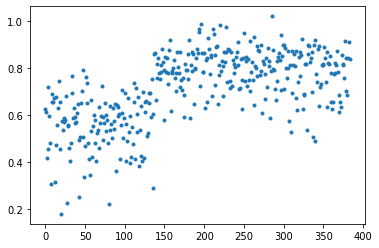

In [30]:
plt.plot(AUC,'.')
AUC.shape[0]**0.5

9.797958971132712

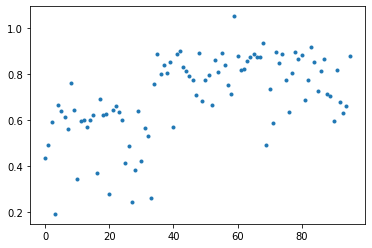

In [31]:
plt.plot(AUC_test,'.')
AUC_test.shape[0]**0.5

In [32]:
Xall = X_train_features.copy() 
Xtest = X_test_features.copy()

Yall = y_train_drug.copy()
Ytest =  y_test_drug.copy()

AUC_all =  AUC[:,None].copy()

In [33]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
from sklearn.model_selection import KFold, cross_val_score
N_per_out = Xall.shape[0]
Xind = np.arange(N_per_out)
k_fold = KFold(n_splits=5,shuffle=True,random_state=0)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Nfold = 0
select_fold = 0
my_val_Folds = []
my_train_Folds = []
Train_5folds_X = []
Val_5folds_X = []
Train_5folds_Y = []
Val_5folds_Y = []
Train_5folds_AUC = []
Val_5folds_AUC = []
for train_id, val_id in k_fold.split(Xind):
    #if Nfold == select_fold:
    print(f"Using Fold {Nfold}")
    Val_5folds_X.append( Xall[val_id, :].copy())
    Train_5folds_X.append( Xall[train_id, :].copy())
    Val_5folds_Y.append( Yall[val_id, :].copy())
    Train_5folds_Y.append( Yall[train_id, :].copy())
    Val_5folds_AUC.append( AUC_all[val_id, :].copy())
    Train_5folds_AUC.append( AUC_all[train_id, :].copy())
    #break
    Nfold +=1
    #my_val_Folds.append(val_id)
    #my_train_Folds.append(train_id)

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

Using Fold 0
Using Fold 1
Using Fold 2
Using Fold 3
Using Fold 4


'\n'

In [34]:
path_to_save = "/home/juanjo/Work_Postdoc/Bench_Mark_DrugResponse_Models/Functional-Random-forest-master/GDSC1_Small_Dataset/"

for i in range(5):
    np.savetxt(path_to_save+"X_Train_fold"+str(i+1)+".csv", Train_5folds_X[i], delimiter=",")
    np.savetxt(path_to_save+"Y_Train_fold"+str(i+1)+".csv", Train_5folds_Y[i], delimiter=",")
    np.savetxt(path_to_save+"X_Val_fold"+str(i+1)+".csv", Val_5folds_X[i], delimiter=",")
    np.savetxt(path_to_save+"Y_Val_fold"+str(i+1)+".csv", Val_5folds_Y[i], delimiter=",")
    np.savetxt(path_to_save+"AUC_Train_fold"+str(i+1)+".csv", Train_5folds_AUC[i], delimiter=",")
    np.savetxt(path_to_save+"AUC_Val_fold"+str(i+1)+".csv", Val_5folds_AUC[i], delimiter=",")
    
np.savetxt(path_to_save+"X_Test.csv", Xtest, delimiter=",")
np.savetxt(path_to_save+"Y_Test.csv", Ytest, delimiter=",")
np.savetxt(path_to_save+"AUC_Test.csv", AUC_test, delimiter=",")

In [35]:
X_columns_CosmicID_DrugID = ["COSMIC_ID","DRUG_ID"]+ X_columns
df_train_X = df_train_drug_new[X_columns_CosmicID_DrugID]
df_group_train_X_cells = df_train_X.drop_duplicates(subset ="COSMIC_ID")
df_group_train_X_cells

NameError: name 'X_columns' is not defined

In [59]:
X_columns_drugs = ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway
X_columns_cells = X_cancer_cell_lines

In [60]:
df_train_X_CellLines =  df_group_train_X_cells[X_columns_cells]
df_train_X_CellLines

,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


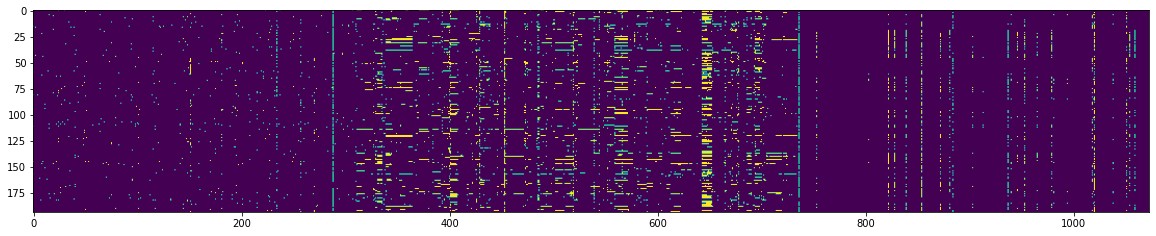

In [61]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_CellLines)

In [62]:
X_columns_CosmicID_DrugID = ["COSMIC_ID","DRUG_ID"]+ X_columns
df_train_X = df_train_drug_new[X_columns_CosmicID_DrugID]
df_group_train_X_drugs = df_train_X.drop_duplicates(subset ="DRUG_ID")
df_group_train_X_drugs

,COSMIC_ID,DRUG_ID,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,687596,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
1,687596,135,1.024,263.20,3.0,0.0,-1.5,0.0,108.0,426.0,...,0,0,0,0,0,0,0,0,0,0
2,687596,136,16.000,334.33,5.0,0.0,-0.4,0.0,147.0,757.0,...,0,0,0,0,0,0,0,0,0,0
3,687596,140,0.064,778.90,12.0,0.0,3.6,0.0,134.0,1690.0,...,0,0,0,0,0,0,0,0,0,0
4,687596,151,10.240,567.70,16.0,0.0,7.6,0.0,85.1,842.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,687997,306,10.240,524.70,11.0,0.0,4.8,0.0,117.0,787.0,...,0,0,0,0,0,0,0,0,0,0
1108,687997,1025,10.000,371.20,10.0,0.0,3.9,0.0,51.1,621.0,...,0,0,0,0,0,0,0,0,0,0
1380,688013,94,10.000,364.40,8.0,0.0,1.9,0.0,57.2,710.0,...,0,0,0,0,0,0,0,0,0,0
1423,688013,1061,5.000,453.50,12.0,0.0,2.1,0.0,78.3,1080.0,...,0,0,0,0,0,0,0,0,0,0


(194, 1073)

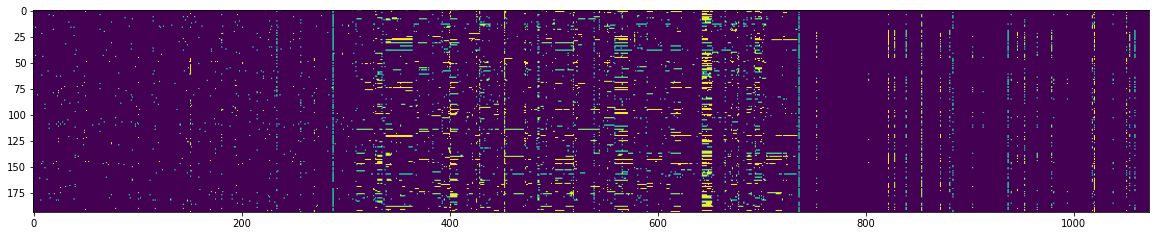

In [63]:
scaler_cells = MinMaxScaler().fit(df_train_X_CellLines)
X_cells_features = scaler_cells.transform(df_train_X_CellLines)
plt.figure(figsize=(20,40))
plt.imshow(X_cells_features)
X_cells_features.shape

In [64]:
Matrix_cells_corr = np.corrcoef(X_cells_features)
print(np.corrcoef(X_cells_features[0,:],X_cells_features[1,:]))

[[1.         0.37397485]
 [0.37397485 1.        ]]


In [65]:
np.savetxt(path_to_save+"Matrix_cells.csv", Matrix_cells_corr, delimiter=",")
Matrix_cells_corr

array([[1.        , 0.37397485, 0.1204981 , ..., 0.28290845, 0.26740543,
        0.01569487],
       [0.37397485, 1.        , 0.11356118, ..., 0.24161317, 0.37865103,
        0.3104968 ],
       [0.1204981 , 0.11356118, 1.        , ..., 0.14244564, 0.14988251,
        0.22996927],
       ...,
       [0.28290845, 0.24161317, 0.14244564, ..., 1.        , 0.09453401,
        0.13423473],
       [0.26740543, 0.37865103, 0.14988251, ..., 0.09453401, 1.        ,
        0.11962363],
       [0.01569487, 0.3104968 , 0.22996927, ..., 0.13423473, 0.11962363,
        1.        ]])

In [66]:
#df_group_train_X_drugs.sort_values("DRUG_ID")
#plt.plot(df_group_train_X_drugs["DRUG_ID"])
#plt.plot(df_group_train_X_drugs.sort_values("DRUG_ID"))
df_group_train_X_drugs_sorted = df_group_train_X_drugs.sort_values("DRUG_ID").reset_index()

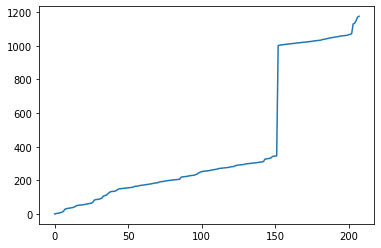

In [67]:
plt.plot(df_group_train_X_drugs_sorted["DRUG_ID"])

In [68]:
df_train_X_Drugs =  df_group_train_X_drugs_sorted[X_columns_drugs]
df_train_X_Drugs

,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,h_bond_donor_count,h_bond_acceptor_count,...,DNA replication,Hormone-related,Genome integrity,WNT signaling,JNK and p38 signaling,Chromatin other,Metabolism,Apoptosis regulation,Chromatin histone methylation,p53 pathway
0,2.0,393.4,8.0,1.0,3.3,0.0,74.7,525.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,0.1,914.2,9.0,0.0,6.0,0.0,195.0,1760.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,398.5,8.0,0.0,2.6,0.0,77.2,636.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,641.6,13.0,0.0,5.0,0.0,111.0,1180.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,475.6,7.0,0.0,4.8,0.0,114.0,644.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,10.0,390.4,7.0,0.0,3.2,0.0,60.9,510.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
204,10.0,328.4,10.0,0.0,4.6,0.0,52.7,387.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
205,5.0,573.7,15.0,0.0,7.8,0.0,132.0,963.0,4.0,6.0,...,0,0,0,0,0,0,0,1,0,0
206,10.0,352.4,8.0,0.0,3.7,0.0,87.6,479.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0


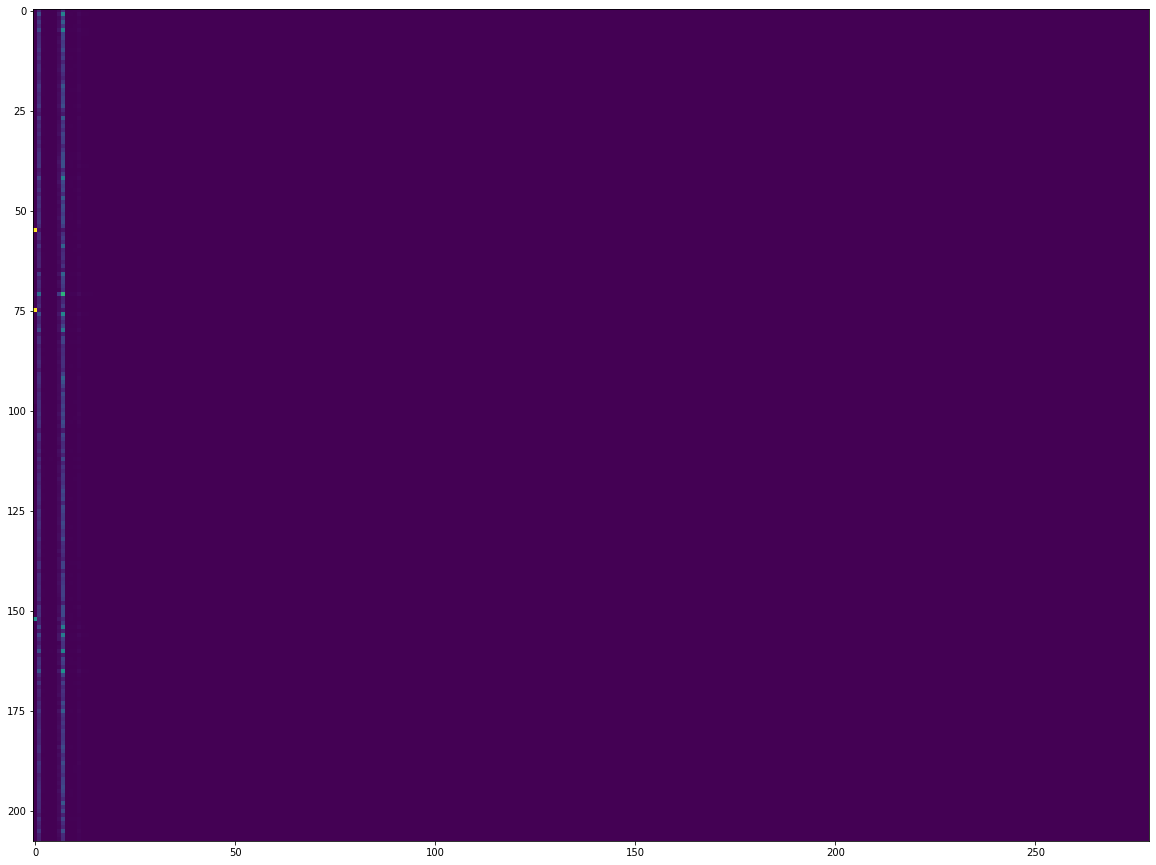

In [69]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_Drugs)

(208, 279)

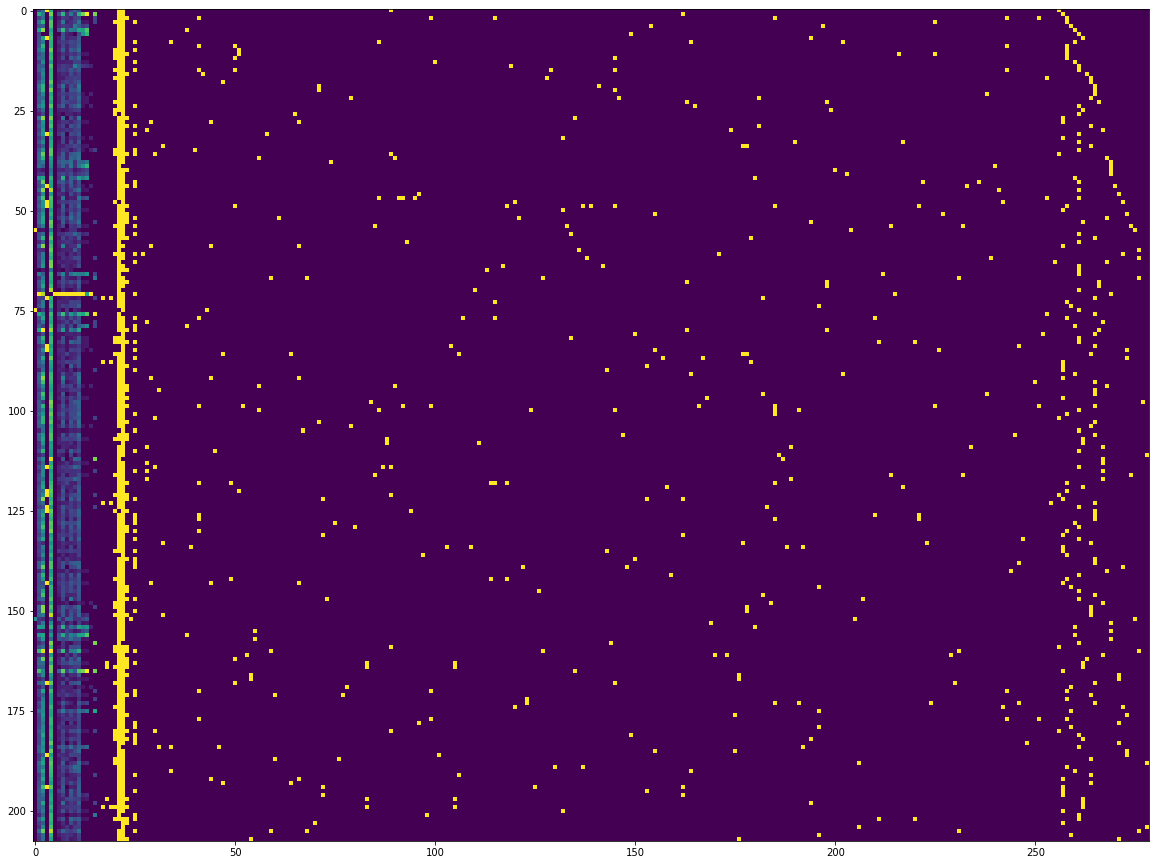

In [70]:
scaler_drugs = MinMaxScaler().fit(df_train_X_Drugs)
X_drug_features = scaler_drugs.transform(df_train_X_Drugs)
#Xtest_drug = scaler.transform(df_test_drug_new[X_columns])
plt.figure(figsize=(20,40))
plt.imshow(X_drug_features)
X_drug_features.shape

In [71]:
Matrix_drug_corr = np.corrcoef(X_drug_features)
print(np.corrcoef(X_drug_features[0,:],X_drug_features[1,:]))

[[1.         0.42778051]
 [0.42778051 1.        ]]


In [72]:
np.savetxt(path_to_save+"Matrix_drugs.csv", Matrix_drug_corr, delimiter=",")
Matrix_drug_corr

array([[1.        , 0.42778051, 0.31725519, ..., 0.41879327, 0.50409128,
        0.40763753],
       [0.42778051, 1.        , 0.3086322 , ..., 0.41507195, 0.46822864,
        0.36990667],
       [0.31725519, 0.3086322 , 1.        , ..., 0.28548114, 0.35360304,
        0.40663241],
       ...,
       [0.41879327, 0.41507195, 0.28548114, ..., 1.        , 0.46355803,
        0.37038302],
       [0.50409128, 0.46822864, 0.35360304, ..., 0.46355803, 1.        ,
        0.45638295],
       [0.40763753, 0.36990667, 0.40663241, ..., 0.37038302, 0.45638295,
        1.        ]])

In [73]:
df_train_X_Drugs

,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,h_bond_donor_count,h_bond_acceptor_count,...,DNA replication,Hormone-related,Genome integrity,WNT signaling,JNK and p38 signaling,Chromatin other,Metabolism,Apoptosis regulation,Chromatin histone methylation,p53 pathway
0,2.0,393.4,8.0,1.0,3.3,0.0,74.7,525.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,0.1,914.2,9.0,0.0,6.0,0.0,195.0,1760.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,398.5,8.0,0.0,2.6,0.0,77.2,636.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,641.6,13.0,0.0,5.0,0.0,111.0,1180.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,475.6,7.0,0.0,4.8,0.0,114.0,644.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,10.0,390.4,7.0,0.0,3.2,0.0,60.9,510.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
204,10.0,328.4,10.0,0.0,4.6,0.0,52.7,387.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
205,5.0,573.7,15.0,0.0,7.8,0.0,132.0,963.0,4.0,6.0,...,0,0,0,0,0,0,0,1,0,0
206,10.0,352.4,8.0,0.0,3.7,0.0,87.6,479.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
#Matrix_drug_corr.shape
#Matrix_cells_corr.shape

In [75]:
val_id

array([   0,   19,   21, ..., 9093, 9096, 9105])

In [76]:
len(IC50)

9108

In [77]:
val_id

array([   0,   19,   21, ..., 9093, 9096, 9105])

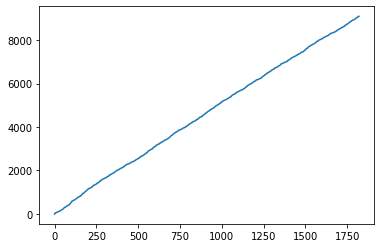

In [78]:
plt.plot(val_id)